In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [5]:
MONTH = 21
YEAR = 12 * MONTH
START = '2013-01-01'
END = '2017-12-31'
DATA_STORE = '../00_data/assets_v1.h5'

ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [6]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [7]:
# with pd.HDFStore(DATA_STORE) as store:
#     prices = (store['quandl/wiki/prices']
#               .loc[idx[START:END, :], ohlcv]
#               .rename(columns=lambda x: x.replace('adj_', ''))
#               .assign(volume=lambda x: x.volume.div(1000))
#               .swaplevel()
#               .sort_index())

#     stocks = (store['us_equities/stocks']
#               .loc[:, ['marketcap', 'ipoyear', 'sector']])

In [8]:
with pd.HDFStore(DATA_STORE) as store:
    prices = store['stocks/prices/daily']
    stocks = store['stocks/base_fundementals']

In [9]:
prices.head()

open     high      low    close  adjusted_close     volume
     date                                                                     
AAPL 1980-12-12  28.7392  28.8736  28.7392  28.7392          0.0997  469033600
     1980-12-15  27.3728  27.3728  27.2608  27.2608          0.0946  175884800
     1980-12-16  25.3792  25.3792  25.2448  25.2448          0.0876  105728000
     1980-12-17  25.8720  26.0064  25.8720  25.8720          0.0898   86441600
     1980-12-18  26.6336  26.7456  26.6336  26.6336          0.0924   73449600

In [10]:
stocks1 = pd.DataFrame(stocks.loc[idx[:, 'General', 'Sector']], columns= ['Sector'])
# stocks2 = pd.DataFrame(stocks.loc[idx[:, 'General', 'IPODate']], columns= ['IPODate'])
# stocks3 = pd.DataFrame(stocks.loc[idx[:, 'Highlights', 'MarketCapitalization']], columns= ['MarketCapitalization'])

# stocks = pd.concat([stocks1, stocks2, stocks3], axis=1)

In [11]:
stocks1.head()

,Sector
AAPL,Technology
MSFT,Technology
AMZN,Consumer Cyclical
GOOGL,Communication Services
TSLA,Consumer Cyclical


## Data Cleaning

In [12]:
# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level=0).size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]

In [13]:
# Align price and meta data
stocks = stocks1[~stocks1.index.duplicated() & stocks1.Sector.notnull()]
stocks.Sector = stocks1.Sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

shared = (prices.index.get_level_values(0).unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [14]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4002921 entries, ('A', '1999-11-18') to ('ZTS', '2023-02-22')
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   open            4002921 non-null  float64
 1   high            4002921 non-null  float64
 2   low             4002921 non-null  float64
 3   close           4002921 non-null  float64
 4   adjusted_close  4002921 non-null  float64
 5   volume          4002921 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 199.2+ MB


## Compute Rolling Average Dollar Volume

In [15]:
# compute dollar volume to determine universe

prices['volume'] = prices['volume'] / 1000

prices['dollar_vol'] = prices[['adjusted_close', 'volume']].prod(axis=1)

prices['dollar_vol_1m'] = (prices.dollar_vol.groupby(level=0)
                           .rolling(window=21, level='date')
                           .mean()).values

prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4002921 entries, ('A', '1999-11-18') to ('ZTS', '2023-02-22')
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             4002921 non-null  float64
 1   high             4002921 non-null  float64
 2   low              4002921 non-null  float64
 3   close            4002921 non-null  float64
 4   adjusted_close   4002921 non-null  float64
 5   volume           4002921 non-null  float64
 6   dollar_vol       4002921 non-null  float64
 7   dollar_vol_1m    3992921 non-null  float64
 8   dollar_vol_rank  3992921 non-null  float64
dtypes: float64(9)
memory usage: 290.8+ MB


## Add Some Basic Factors

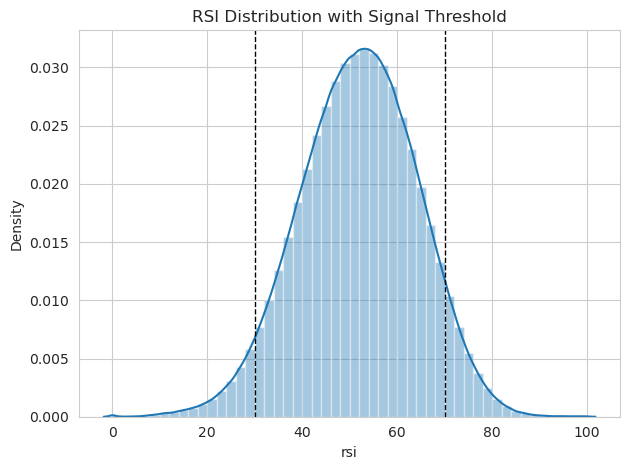

In [16]:
## RSI
prices['rsi'] = prices.groupby(level=0).close.apply(RSI)
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()

In [17]:
## BBANDS BROKE!

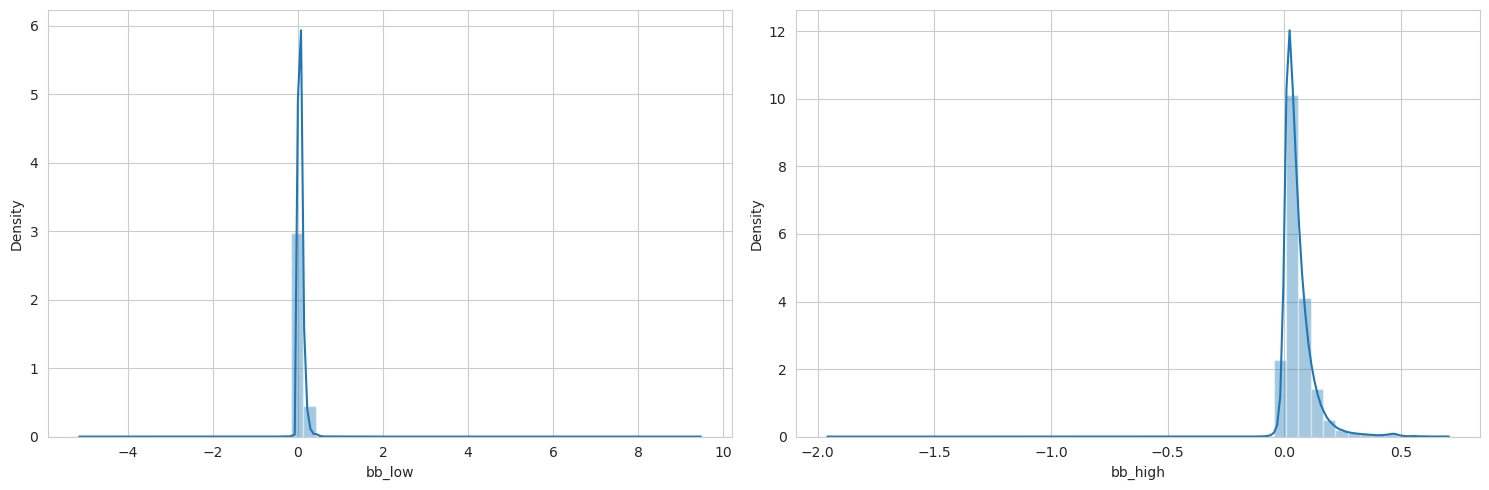

In [18]:
# Bollinger Bands
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

prices = (prices.join(prices
                      .groupby(level=0)
                      .close
                      .apply(compute_bb), rsuffix = "_"))

prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout()

<Axes: xlabel='atr', ylabel='Density'>

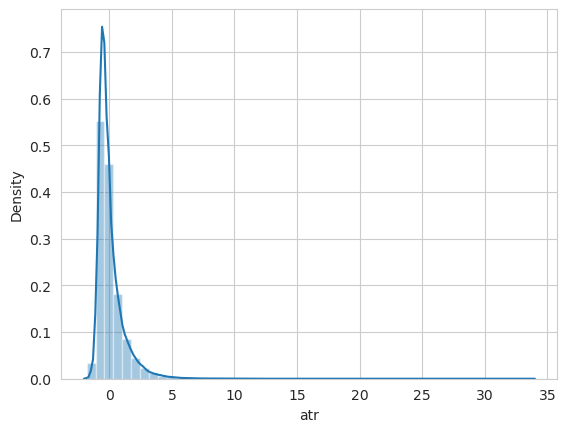

In [19]:
## Average True Range
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

prices['atr'] = (prices.groupby(level=0, group_keys=False)
                 .apply(compute_atr))

sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna())

In [20]:
## MACD
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

prices['macd'] = (prices
                  .groupby(level=0, group_keys=False)
                  .close
                  .apply(compute_macd))

prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    3,986,421.0
mean             0.0
std              1.0
min            -25.2
0.1%            -8.8
1%              -3.4
2%              -2.3
3%              -1.8
4%              -1.5
5%              -1.3
50%              0.0
95%              1.3
96%              1.4
97%              1.6
98%              1.9
99%              2.4
99.9%            4.6
max             15.0
Name: macd, dtype: object

<Axes: xlabel='macd', ylabel='Density'>

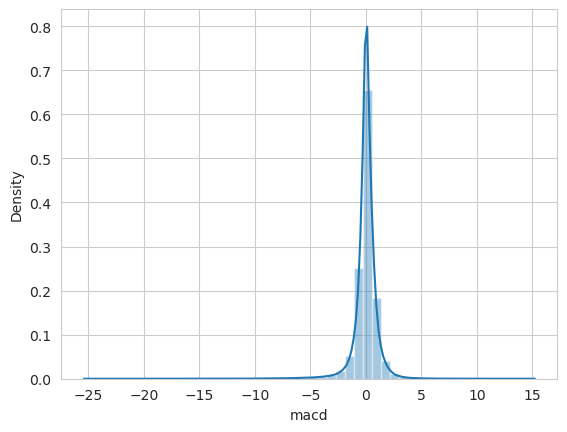

In [21]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna())

## Compute Lagged Returns

In [22]:
lags = [1, 5, 10, 21, 42, 63]
returns = prices.groupby(level=0).close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')
q = 0.0001

In [23]:
# winsorize outliers
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level=0).close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

In [24]:
# shift lagged returns
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level=0)
                                           [f'return_{lag}d'].shift(t * lag))

In [25]:
## Compute Forward Returns
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level=0)[f'return_{t}d'].shift(-t)

## Combine Price and Meta Data

In [26]:
prices = prices.join(stocks[['Sector']]) #on = index.getsectorlevels()

ValueError: cannot join with no overlapping index names

## Create Sector and Dummy Variables 04_03